# Analyze Heavy Correlations

This jupyter notebook analyzes one-time correlations calculated from the heavy trajectories of ReadRun.py

Observables are:
- Self-intermediate scattering function
- Mean-square displacement
- Force-force correlations
- Velocity-velocity correlations
- Force-velocity correlations

In [1]:
from __future__ import print_function #for compatibility between python 2 and 3
import hoomd #hoomd is the MD package from the Glotzer group
from hoomd import md #md is the subsection strictly about the properties of the system
import sys
import os 
import numpy as np
import gsd.pygsd
import gsd.hoomd
import lib.module_measurements as med
from gsd import fl
from freud.box import Box
from matplotlib import pyplot as plt
from scipy.stats import sem


## Import data

In [2]:
#Read L and dt
name='./heavyTraj/L.txt'
f=open(name,'rt')
L=np.float64(f.readline())
dt=np.float64(f.readline())
f.close()

In [3]:
#Read list of times
timesName='./heavyTraj/times.txt'
timelist=np.loadtxt(timesName)
ntimes=len(timelist)
print('There are ',ntimes,' configurations in total')


#Read trajectory
# trajName='./heavyTraj/traj.gsd'
# traj = gsd.hoomd.HOOMDTrajectory(fl.GSDFile(trajName,'rb'))
# box = traj[-1].configuration.box
# fbox = Box(Lx=box[0],Ly=box[1],Lz=box[2],xy=box[3],xz=box[4],yz=box[5])
# L=box[0]
# pos = []
# vel = []
# for f in traj:
#     pos.append(np.copy(f.particles.position))
#     vel.append(np.copy(f.particles.velocity))
# if len(pos)!= ntimes:
#     raise ValueError('Time list is inconsistent with trajectory. ntimes=%d, len(pos)=%d'%(ntimes,len(pos)))

#Read accelerations
pos = []
vel = []
acc = []
fpos=open('./heavyTraj/pos.npy','rb')
fvel=open('./heavyTraj/vel.npy','rb')
facc=open('./heavyTraj/acc.npy','rb')
for i in range(ntimes):
    pos.append(np.load(fpos))
    vel.append(np.load(fvel))
    acc.append(np.load(facc))
fpos.close()
fvel.close()
facc.close()

#Relevant quantities
Natoms=len(pos[0])
initialPositions=pos[0]
pos=np.array(pos)
vel=np.array(vel)
acc=np.array(acc)

#Sort observables
twlist=np.unique(timelist[:,0])
ntw=len(twlist)
# print("twlist: ",twlist)
print("ntw: ",ntw)

tlist=[]
poslist=[]
vellist=[]
acclist=[]
nt=0
for itw in range(ntw):
    tw=twlist[itw]
    thistw=np.where(timelist[:,0]==tw)
    first=thistw[0][0]
    last=thistw[0][-1]+1
    if last-first>nt: 
        nt=last-first
        tlist=np.array(timelist[first:last][:,1]-timelist[first][1])
    poslist.append(pos[first:last])
    vellist.append(vel[first:last])
    acclist.append(acc[first:last])

#Remove incomplete entries
for itw in np.arange(ntw-1,-1,-1):
    if len(poslist[itw]) != nt:
        assert(len(vellist[itw]) == len(poslist[itw]))
        assert(len(acclist[itw]) == len(poslist[itw]))
        del poslist[itw]
        del vellist[itw]
        del acclist[itw]
        twlist=np.delete(twlist,itw)
        
#poslist, vellist and acclist have the shape: [itw, it, particle, component]
ntw=len(twlist)
print("new ntw: ",ntw)
print('tlist: ',tlist)
print('nt: ',nt)
print(np.shape(poslist))
print(np.shape(vellist))
print(np.shape(acclist))
del pos,vel,acc,timelist


There are  8600  configurations in total
ntw:  201
new ntw:  199
tlist:  [   0.    1.    2.    3.    4.    5.    6.    7.    8.   10.   11.   13.
   15.   17.   19.   22.   26.   29.   34.   39.   45.   52.   60.   69.
   79.   91.  105.  121.  139.  160.  184.  212.  244.  281.  323.  372.
  429.  494.  568.  655.  754.  868.  999.]
nt:  43
(199, 43, 65, 3)
(199, 43, 65, 3)
(199, 43, 65, 3)


## Calculate observables

In [4]:
#Wave vector for the self-intermediate scattring function
# k =[2 pi/L](n1,n2,n3) and permutations
n1=1; n2=3; n3=4

msd = np.zeros((ntw, nt), dtype=np.float64)
Fk  = np.zeros((ntw, nt), dtype=np.float64)
CPP = np.zeros((ntw, nt), dtype=np.float64)
CFP = np.zeros((ntw, nt), dtype=np.float64)
CFF = np.zeros((ntw, nt), dtype=np.float64)
for itw in range(ntw):
    initialPositions[:]=poslist[itw][0][:]
    for iframe in range(0, nt):
        msd[itw][iframe]=med.PeriodicSquareDistance(poslist[itw][iframe], initialPositions, L)/Natoms
        all_displacements=med.PeriodicDisplacement(poslist[itw][iframe], initialPositions, L)
        Fk[itw][iframe]=med.ComputeFkt(n1, n2, n3, L, all_displacements)

    CPP[itw]=np.array([np.mean([np.inner(vellist[itw][0][atom],vellist[itw][time][atom]) for atom in range(Natoms)]) for time in range(nt)])/3.
    CFP[itw]=np.array([np.mean([np.inner(acclist[itw][0][atom],vellist[itw][time][atom]) for atom in range(Natoms)]) for time in range(nt)])/3.
    CFF[itw]=np.array([np.mean([np.inner(acclist[itw][0][atom],acclist[itw][time][atom]) for atom in range(Natoms)]) for time in range(nt)])/3.

obs={
    'msd':{'mean': np.mean(msd,axis=0), 'err': sem(msd,axis=0)},
    'Fk':{'mean': np.mean(Fk,axis=0), 'err': sem(Fk,axis=0)},
    'CPP':{'mean': np.mean(CPP,axis=0), 'err': sem(CPP,axis=0)},
    'CFP':{'mean': np.mean(CFP,axis=0), 'err': sem(CFP,axis=0)},
    'CFF':{'mean': np.mean(CFF,axis=0), 'err': sem(CFF,axis=0)},
}


## Plot

### Mean Square Displacement

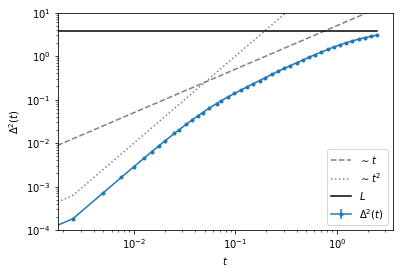

In [18]:
x=tlist*dt

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')
plt.ylim((1e-4,10))
plt.errorbar(x,obs['msd']['mean'],yerr=obs['msd']['err'],label='$\Delta^2(t)$',marker='.')
plt.plot(x,5*x,label='$\sim t$',linestyle='--',color='gray')
plt.plot(x,100*np.square(x),label='$\sim t^2$',linestyle=':',color='gray')
plt.plot(x,L*np.ones(len(x)),label='$L$',color='black')
plt.ylabel('$\Delta^2(t)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

### Self-intermediate scattering function

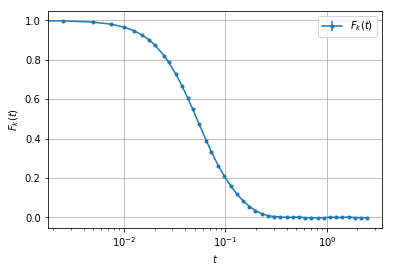

In [6]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
plt.errorbar(x,obs['Fk']['mean'],yerr=obs['Fk']['err'],label='$F_k(t)$',marker='.')
plt.legend()
plt.ylabel('$F_k(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Momentum-momentum correlation function

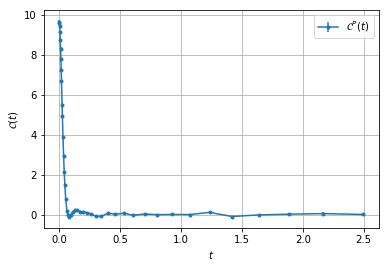

In [20]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')
plt.errorbar(x,obs['CPP']['mean'],yerr=obs['CPP']['err'],label='$\mathcal{C}^{P}(t)$',marker='.')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-momentum correlation function

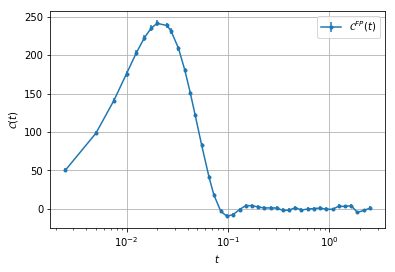

In [8]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')
plt.errorbar(x,obs['CFP']['mean'],yerr=obs['CFP']['err'],label='$\mathcal{C}^{FP}(t)$',marker='.')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-force correlation function

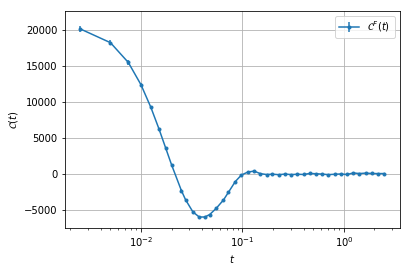

In [9]:
#plt.semilogx(x,obs['CFF']['mean'],label='$\mathcal{C}^{F}(t)$',marker='.')
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log", nonposx='mask')
plt.errorbar(x,obs['CFF']['mean'], yerr=obs['CFF']['err'],label='$\mathcal{C}^{F}(t)$',marker='.')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()
